# Problem 2

The electrostatic potential of a point charge is:

$$
V(r) = \frac{q}{4\pi r}
$$

where we use $\epsilon _0=1$.
A simple dipole is just two charges of opposite sign, so we can write the vector potential of a dipole, parallel to the x-axis with length of $d=0.5$ centered in a box of length $L=1$ as:

$$
V(x,y) = \frac{q}{4\pi\sqrt{(x-0.25)^2+(y-0.5)^2}-\sqrt{(x-0.75)^2+(y-0.5)^2)}}
$$

at $z=0$. For our problem $q=10$

In [2]:
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time

In [3]:
import numpy as np
import time
import cmath

class Poisson :
    def __init__ (self, L, rho_init, method, calcError = True):
        self.L = L                    # number of interior points in x and y
        self.omega = 1.88177          # over-relaxation parameter for L = 50
        self.N = L + 2                # interior plus two boundary points
        N=self.N
        self.V = np.zeros( (N, N) )   # potential to be found
        self.VNew = np.zeros( (N, N) )# new potential after each step
        self.h = 1.0 / (L + 1)        # lattice spacing assuming size in x and y = 1
        self.nsmooth = 3              # smoothing steps for multigrid method
        self.rho = np.array( rho_init )
        self.method=method        
        self.calcError = calcError
        self.error  = 0. if self.calcError else None
        self.errors = [] if self.calcError else None


    def __call__(self):
        return getattr(self,self.method)()

    def update(self):
        if self.calcError :
            self.error = np.sum( np.abs(self.V - self.VNew) ) / self.V.size
        self.V[:,:] = self.VNew[:,:]
        if self.calcError :
            self.errors.append(self.error)
            return self.error
        else :
            return None

        
    def Jacobi(self) :
        '''
        Jacobi algorithm for a single iterative step
        '''
        self.VNew = self.JacStep(self.VNew,self.V,self.h,self.rho)
        return self.update()

    def JacStep(self, u, v, h, rho):
        '''
        Jacobi algorithm on arbitrary inputs. Called once by "Jacobi".
        Called many times by "MultiGrid"
        '''
        u[1:-1,1:-1] = np.add.reduce([
            0.25*v[1:-1, 2:] ,
            0.25*v[1:-1, 0:-2],
            0.25*v[2:,   1:-1] ,
            0.25*v[0:-2, 1:-1] ,
            0.25*h**2 * rho[1:-1,1:-1]])
        return u

            
    def GaussSeidel(self):
        ''' 
        Gauss-Seidel algorithm for one iterative step
        '''
        self.VNew[:,:] = self.V[:,:]
        # perform Gauss-Seidel update
        for i in range(1, self.L+1):
            for j in range(1, self.L+1):
                self.VNew[i][j] = 0.25 * (self.VNew[i-1][j] + self.VNew[i+1][j] +
                                            self.VNew[i][j-1] + self.VNew[i][j+1] +
                                            self.h**2 * self.rho[i][j])
        return self.update()


    def SuccessiveOverRelaxation(self):
        '''
        Averages between G-S and J methods. 
        '''

        # update even sites in red-black scheme
        for i in range(1, self.L+1):
            for j in range(1, self.L+1):
                if (i + j) % 2 == 0:
                    self.VNew[i][j] = (1 - self.omega) * self.V[i][j] + self.omega / 4 * (
                                 self.V[i-1][j] + self.V[i+1][j] + self.V[i][j-1] +
                                 self.V[i][j+1] + self.h**2 * self.rho[i][j] )

        # update odd sites in red-black scheme
        for i in range(1, self.L+1):
            for j in range(1, self.L+1):
                if (i + j) % 2 != 0:
                    self.VNew[i][j] = (1 - self.omega) * self.V[i][j] + self.omega / 4 * (
                                 self.VNew[i-1][j] + self.VNew[i+1][j] + self.VNew[i][j-1] +
                                 self.VNew[i][j+1] + self.h**2 * self.rho[i][j] )
        return self.update()


    def FFT(self):
        '''
        Explicitly solves differential equation in Fourier domain
        '''
        
        # Make a grid to get indices
        x = np.arange(self.N)
        y = np.arange(self.N)
        xx,yy = np.meshgrid(x,y)
        # Construct root of unity
        i = 0. + 1.j
        W = cmath.exp( 2 * i * cmath.pi / float(self.N) )
        # Get the denominator using the grid
        d = 4.0 - np.power(W, xx ) - np.power(W, -xx) - np.power(W, yy) - np.power(W, -yy)
        valid_d = (d > 0.0)
        # FFT of rho columns
        rhof = np.fft.fft(self.rho, axis=0)
        # FFT of rho rows
        rhof = np.fft.fft(rhof,axis=1)
        # Solve for V in Fourier domain
        Vf = np.divide( rhof * self.h**2, d, out=np.zeros_like(d, dtype=complex), where=np.absolute(d)>0)
        # IFFT of V rows
        self.V = np.fft.ifft( Vf, axis=0)
        # IFFT of V columns
        self.V = np.fft.ifft( self.V, axis=1)
        return 



In [4]:
L = 50
N = L+2
q1 = 10.0                # point charge of 10
q2 = -10.0
i = N // 4               # Index of one fourth the length
j = (3 * N) // 4         # Three fourths of the Length
k = N // 2               # One half of the length
h = 1/(L+1)
rho1 = np.zeros( (N,N))
rho2 = np.zeros( (N,N))
rho1[k,i] = q1 / h**2    # charge density for positive part
rho2[k,j] = q2 / h**2    #   ''      ''   ''  negative  ''
rho = rho1 + rho2

nsteps = 100
steps = np.arange(nsteps)
p = Poisson(L,rho, 'Jacobi')
for i in steps : 
    p()

5.774593028389807
2704


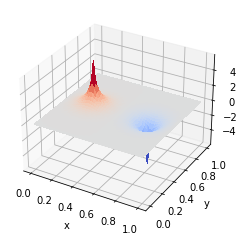

In [8]:
# Define the axes
x = np.arange(0, p.h*(p.L+2), p.h)
y = np.arange(0, p.h*(p.L+2), p.h)
# Get the grid
X, Y = np.meshgrid(x, y)
# Set Z to the poisson V[i][j]
Z = np.array( p.V )

fig = plt.figure(1)
ax = fig.gca(projection='3d')
sur = ax.plot_surface( X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False )
plt.xlabel("x")
plt.ylabel("y")
print(np.max(Z))
print(np.size(Z))

70.99278711723889


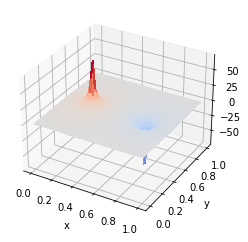

In [11]:
# Exact Solution
potential = np.zeros( (N,N))
potential = q1 / ( 4 * np.pi *  ( ( X - 0.25 ) ** 2 + ( Y - 0.5 ) ** 2 ) ** ( 1 / 2 ) ) \
          + q2 / ( 4 * np.pi *  ( ( X - 0.75 ) ** 2 + ( Y - 0.5 ) ** 2 ) ** ( 1 / 2 ) )

fig_e = plt.figure(1)
ax_e = fig_e.gca(projection='3d')
sur_e = ax_e.plot_surface( X, Y, potential, rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False )

plt.xlabel("x")
plt.ylabel("y")